# **DLIP Tutorial - PyTorch**
# Transfer Learning using Pre-trained Models (Classification) - Assignment

Y.-K. Kim
(updated 2022. 5. 10) 

===================

Create a CNN model 'EfficientNet(efficientnet_b7)' and Train with Custom Dataset



# Environment Setup

we will mount 'Google Drive' to load Python modules and image data. 
- [download modules](https://drive.google.com/file/d/1hjrWkcvBTiI-5yGtWPvsYVdaE7YLNWDo/view?usp=sharing)
- [download dataset(cat/dog)](https://drive.google.com/file/d/1KYOAxXDIqp_hhE97WWQ_C8TeGFHWkxqG/view?usp=sharingg)

upload *resources* to the following path in Google Drive. **'MyDrive/HGU_DLIP'**

![image](https://user-images.githubusercontent.com/23421059/167506132-b4b921e0-661f-4a11-b4b4-4790d82dac54.png)


In [7]:
import os

root_path = r"C:/Users/hanmu/Desktop/DLIP FILES/DeepLearning_TUTORIAL/5.Pytorch_Classification"  # change dir to your project folder
os.chdir(root_path)  #change dir
os.getcwd()

'C:\\Users\\hanmu\\Desktop\\DLIP FILES\\DeepLearning_TUTORIAL\\5.Pytorch_Classification'

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from set_parameter_requires_grad import set_parameter_requires_grad
from initialize_model import initialize_model
from train import train
from test import test

from IPython.display import Image

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")
if torch.cuda.is_available(): print(f'Device name: {torch.cuda.get_device_name(0)}') 


Using cuda device
Device name: NVIDIA GeForce RTX 3070 Laptop GPU


# MODEL

Basically, the classification models provided by torchvision are trained on ImageNet and consist of 1000 output layers.

However, in the model for fine-tuning with other datasets, the number of output layers should be different depending on the class.

Here, we use the initialize_model() function provided in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) to change the output stage of the model.

initialize_model() is a function that helps to initialize the fine-tuning of some models.

If the model is not in the function, the output layer information can be known by printing the model with the print() function.

In [9]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = "efficientnet_b7"

# Number of classes in the dataset
num_classes = 2

feature_extract = True   # True: only update the reshaped layer params, False: finetune the whole model, 

####################################################################
### add your code for 'efficientnet_b7' in 'initialize_model.py' ###
####################################################################

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)  
model_ft = model_ft.to(device)

from torchsummary import summary

summary(model_ft, (3,input_size,input_size))

input_size

AttributeError: 'EfficientNet' object has no attribute '_fc'

# Prepare Datasets: kaggle cats and dogs

**TO DO**

download the kaggle cats and dogs dataset: [download link](https://www.microsoft.com/en-us/download/details.aspx?id=54765)

In [5]:
"""
    Data was downloaded to the working directory (code file)
    Path : 5.Pytorch_Classification - kagglecatsanddogs - Petimages (train / test)
    Process of unzip is not requeired
"""

'\n    Data was downloaded to the working directory (code file)\n    Path : 5.Pytorch_Classification - kagglecatsanddogs - Petimages (train / test)\n    Process of unzip is not requeired\n'

The images in the prepared dataset have different sizes. In order to be used as a learning model, the following process is required. (refer to part2)

- Assign the images in the folder to training/test data for learning
- Same pre-processing as ImageNet data for input of learning model

In [19]:
# Top level data directory. Here we assume the format of the directory conforms 
# to the ImageFolder structure

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./kagglecatsanddogs/PetImages"

# Data augmentation and normalization for training
# Just normalization for validation
# Normalized with ImageNet mean and variance
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...!")

training_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
test_data = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['test'])

classes = ['Cat', 'Dog']
print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")


Initializing Datasets and Dataloaders...!
train dataset length = 17502
test  dataset length = 7498


Use DataLoader to make dataset iterable.

In [17]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([8, 3, 600, 600]) torch.int64
Shape of y: torch.Size([8]) torch.int64


# Optimization Setup

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

- Linear regression->Mean Squared Error
- Classification->Cross entropy

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)

# Train and Test the model

In [13]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_ft, loss_fn, optimizer, device, 15)
    test(test_dataloader, model_ft, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 0.250283  [    0/17502]
loss: 0.456360  [  120/17502]
loss: 0.748246  [  240/17502]
loss: 0.166394  [  360/17502]
loss: 0.464267  [  480/17502]
loss: 0.313820  [  600/17502]
loss: 0.261342  [  720/17502]
loss: 0.574351  [  840/17502]
loss: 0.351642  [  960/17502]
loss: 0.312633  [ 1080/17502]
loss: 0.140710  [ 1200/17502]
loss: 0.448276  [ 1320/17502]
loss: 0.206871  [ 1440/17502]
loss: 0.063766  [ 1560/17502]
loss: 0.176114  [ 1680/17502]
loss: 0.200986  [ 1800/17502]
loss: 0.075510  [ 1920/17502]
loss: 0.549038  [ 2040/17502]
loss: 0.567758  [ 2160/17502]
loss: 0.153453  [ 2280/17502]
loss: 0.263231  [ 2400/17502]
loss: 0.135177  [ 2520/17502]
loss: 0.521735  [ 2640/17502]
loss: 0.062560  [ 2760/17502]
loss: 0.092531  [ 2880/17502]
loss: 0.177042  [ 3000/17502]
loss: 0.242536  [ 3120/17502]
loss: 0.248391  [ 3240/17502]
loss: 0.155572  [ 3360/17502]
loss: 0.245048  [ 3480/17502]
loss: 0.784999  [ 3600/17502]
loss: 0.403274  [ 3720/17502]


# Visualize test results

Select random test images and evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


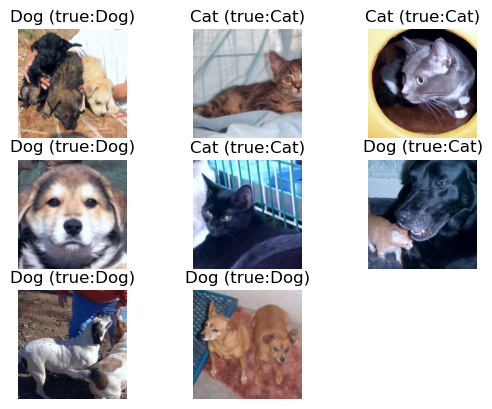

In [20]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)
pred = model_ft(images)
predicted=pred.argmax(1);

figure = plt.figure()
num_of_images = min(batch_size, 9)

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.224  + 0.456).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

Plot heatmap (confusion matrix)

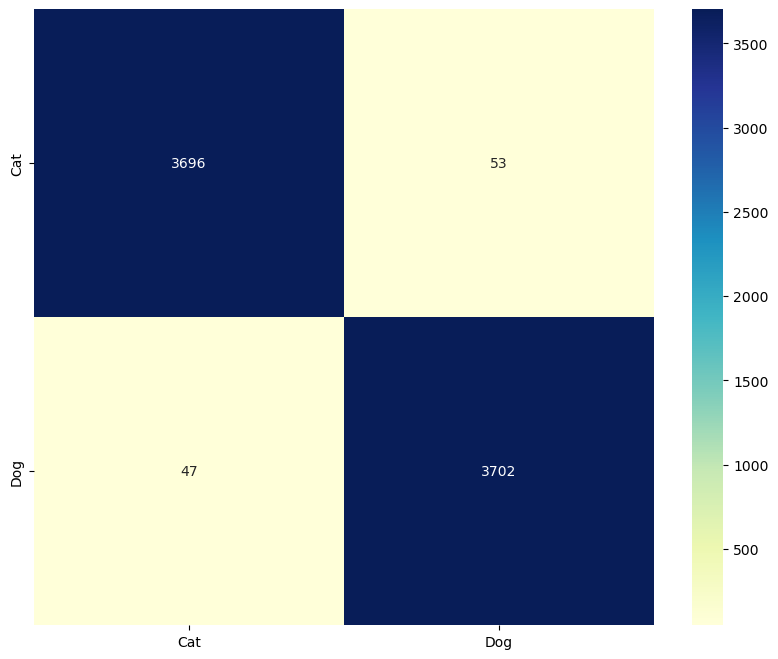

In [21]:
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()

# Saving Models
* save the structure of this class together with the model

In [ ]:
torch.save(model_ft, f"{model_name}_ft(kagglecatsanddogs).pth")

**Process anlaysis**


1. The pre-trained model utilized for transfer learning in this assignment is Efficient-B7. Traditional Convolutional Neural Networks (CNNs) have typically applied one of the following methods: increasing the number of channels, deepening the layer depth, or enhancing the resolution. However, this study casts doubt on such an approach, applying a compound scaling method that integrates all three strategies.

2. Compond Model Scailing
- Flops : Floating point Operation Per Second 
- depth : Alpha, width : Beta, resolution : Gamma
- find Alpha, Beta, Gamma value that satisfy Alpha x Beta^2 x Gamma^2 = 2 with grid search

3. Subsequently, the Kaggle Cats and Dogs dataset is applied to the transfer learning process. This dataset is divided into test and training data, with each of these further divided into two categories, Cats and Dogs. The training data comprises approximately 8,800 images for each category. The test set consists of approximately 3,500 images per class.

4. Due to the addition of data, a decision must be made to either conduct transfer learning or apply fine-tuning techniques. In the former case, setting 'feature_extract' to 'True' enables this process, while in the latter, setting it to 'False' does. When implementing transfer learning, only the output layer is modified in the pre-trained model through the initialize model function.

5. Following this, for training purposes, the training data undergoes processes such as data augmentation and horizontal flipping to prevent overfitting. Only resizing was applied to the test set (validation set). Through these processes, transfer learning is executed.